In [1]:
from fastai.vision.all import *

In [2]:
path = Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Water Bodies Dataset')

In [3]:
path_im = path/'Images'
path_lbl = path/'Masks'

In [4]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

<AxesSubplot:>

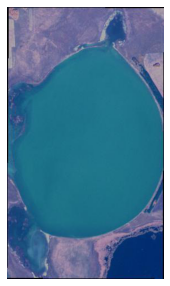

In [5]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [6]:
get_msk = lambda o: path/'Masks'/f'{o.stem}{o.suffix}'

<AxesSubplot:>

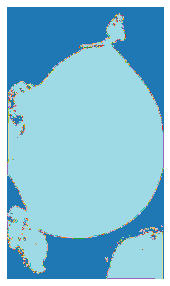

In [7]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [8]:
tensor(msk)

tensor([[  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ..., 255,   0,   1],
        [  0,   0,   0,  ..., 255,   0,   1],
        [  0,   0,   0,  ..., 255,   0,   1]], dtype=torch.uint8)

In [9]:
codes = ['land', 'water']

In [10]:
sz = msk.shape; sz

(487, 280)

In [11]:
half = tuple(int(x/2) for x in sz); half

(243, 140)

In [12]:
water_bd =DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),
                    get_y=get_msk,
                    item_tfms=Resize(256),
                    batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*imagenet_stats), 
                                IntToFloatTensor(div_mask=255.0)]
                   )

In [13]:
dls = water_bd.dataloaders(path/'Images', bs=1, num_workers=0)

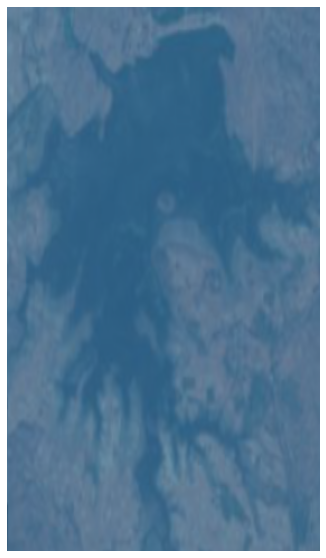

In [14]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [15]:
dls.vocab = codes

In [16]:
name2id = {v:k for k,v in enumerate(codes)}

In [17]:
name2id

{'land': 0, 'water': 1}

In [18]:
water_code = name2id['land']

In [19]:
def acc_water_bd(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != water_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [20]:
opt = ranger

In [21]:
learn = unet_learner(dls, resnet18, metrics=acc_water_bd, self_attention=True, act_cls=Mish, opt_func=opt)

In [22]:
learn.summary()

DynamicUnet (Input shape: 1)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 64 x 244 x 140  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [23]:
lr = 1e-3

In [24]:
learn.fit_flat_cos(5, slice(lr))

epoch,train_loss,valid_loss,acc_water_bd,time
0,0.331720,0.487391,nan,04:26
1,0.342061,0.769229,nan,03:55
2,0.265807,0.550709,nan,03:54
3,0.548322,0.472401,nan,03:53
4,0.207231,0.472515,nan,03:53


In [25]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'
learn.save(data_path + 'water_bd_seg_stage_full')
learn.load(data_path + 'water_bd_seg_stage_full');

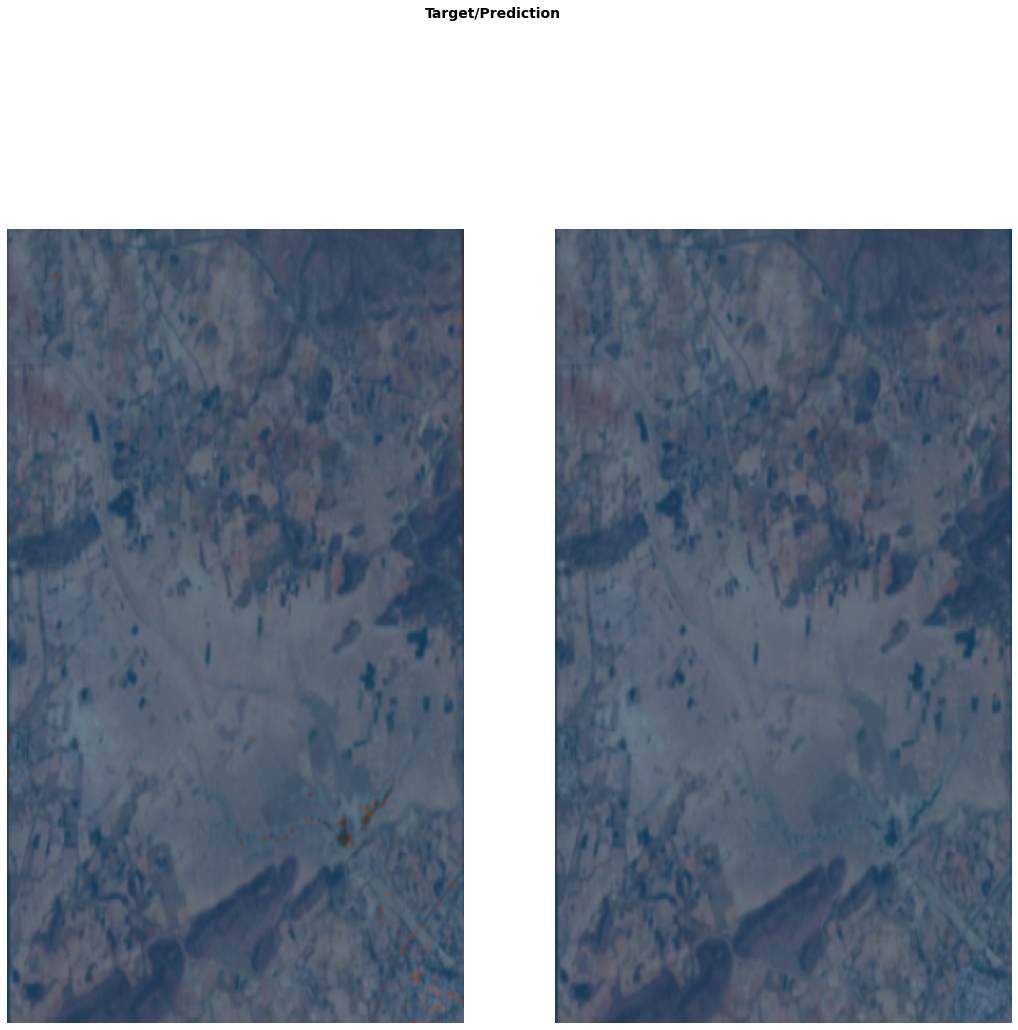

In [26]:
learn.show_results(max_n=4, figsize=(18,18))

In [27]:
lrs = slice(lr/400, lr/4)

In [28]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [29]:
learn.unfreeze()

In [30]:
learn.fit_flat_cos(6, lrs)

epoch,train_loss,valid_loss,acc_water_bd,time
0,0.216977,0.495247,nan,04:05
1,0.224614,0.513483,nan,04:03
2,0.220676,0.877203,nan,04:03
3,0.212536,0.549075,nan,04:03
4,0.290169,0.664568,nan,04:04
5,0.194612,0.403632,nan,04:04


In [31]:
learn.save(data_path + 'water_bd_seg_model_full')

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/water_bd_seg_model_full.pth')

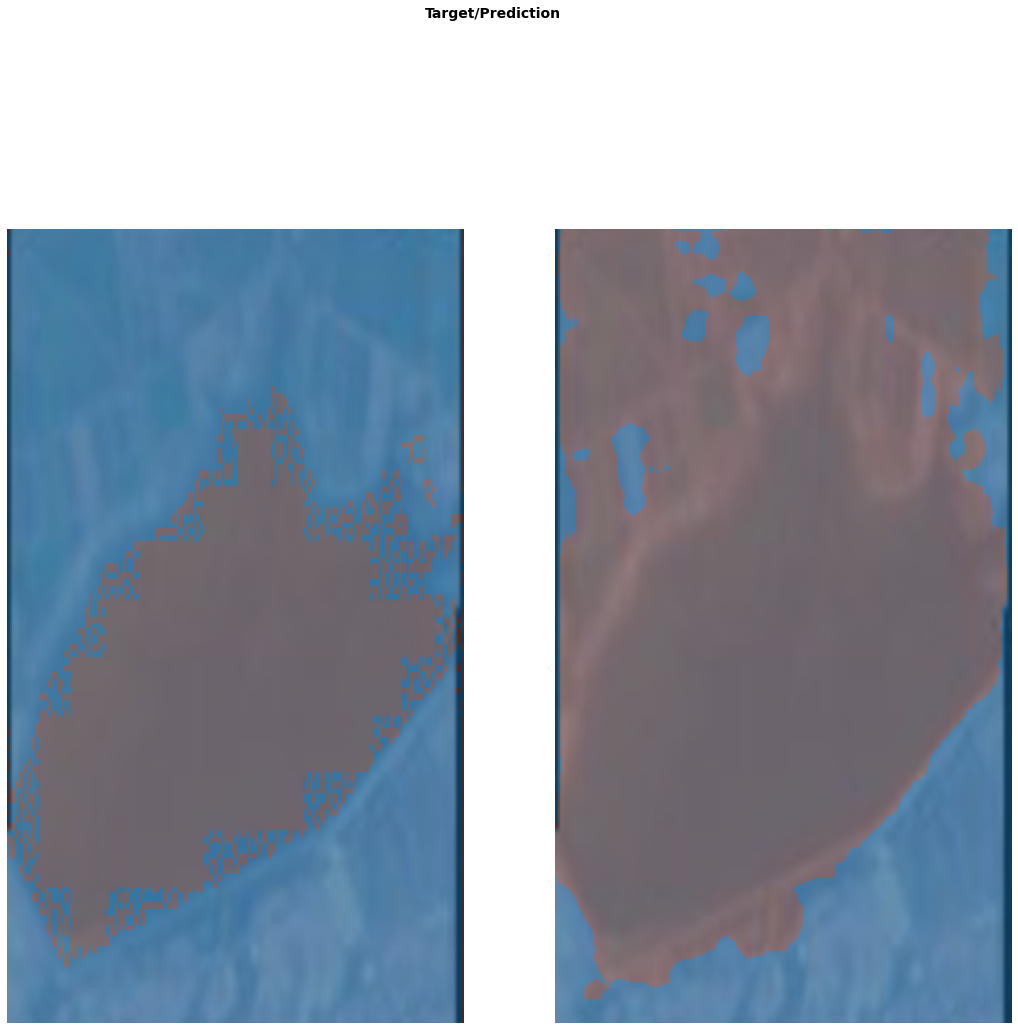

In [32]:
learn.show_results(max_n=4, figsize=(18,18))

In [33]:
dl = learn.dls.test_dl(fnames[:5])

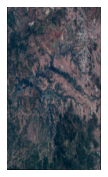

In [34]:
dl.show_batch()

In [35]:
preds = learn.get_preds(dl=dl)

In [36]:
preds[0].shape

torch.Size([5, 2, 487, 280])

In [37]:
len(codes)

2

In [38]:
pred_1=preds[0][0]

In [39]:
pred_1.shape

torch.Size([2, 487, 280])

In [40]:
pred_arx = pred_1.argmax(dim=0)

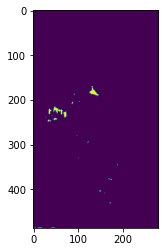

In [41]:
plt.imshow(pred_arx)

In [42]:
pred_arx = pred_arx.numpy()

In [43]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [44]:
im = Image.fromarray(rescaled)

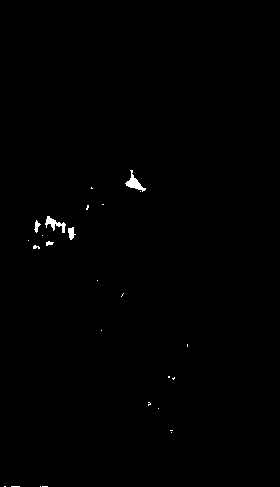

In [45]:
im

In [46]:
im.save(data_path + 'test.png')

In [47]:
for i, pred in enumerate(preds[0]):
    pred_arg = pred.argmax(dim=0).numpy()
    rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(data_path + f'Image_{i}.png')

In [48]:
torch.save(preds[0][0],data_path + 'Image_1.pt')

In [49]:
pred_1 = torch.load(data_path + f'Image_1.pt')

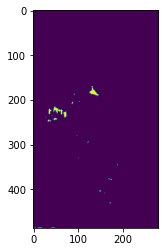

In [50]:
plt.imshow(pred_1.argmax(dim=0))

In [51]:
class CrossEntropyLossFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x): return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [52]:
weights = torch.tensor([[0.9]*31 + [1.1]]).cuda()

In [53]:
weights

tensor([[0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 1.1000]], device='cuda:0')

In [54]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [55]:
learn = unet_learner(dls, resnet18, metrics=acc_water_bd, loss_func=loss_func)

### XResNet and ImageNette

In [1]:
from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
tfms = [[PILImage.create],[parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [4]:
items = get_image_files(path)

In [5]:
split_idx = GrandparentSplitter(valid_name='val')(items)

In [6]:
dsets = Datasets(items, tfms, splits=split_idx)

In [7]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=0)

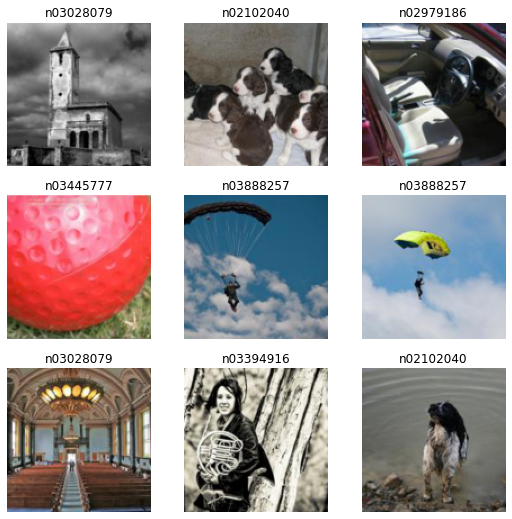

In [8]:
dls.show_batch()

In [9]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [10]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]

In [11]:
dsets = Datasets(items, tfms, splits=split_idx)

In [12]:
dls = dsets.dataloaders(after_item=item_tfms,after_batch=batch_tfms,bs=64, num_workers=0)

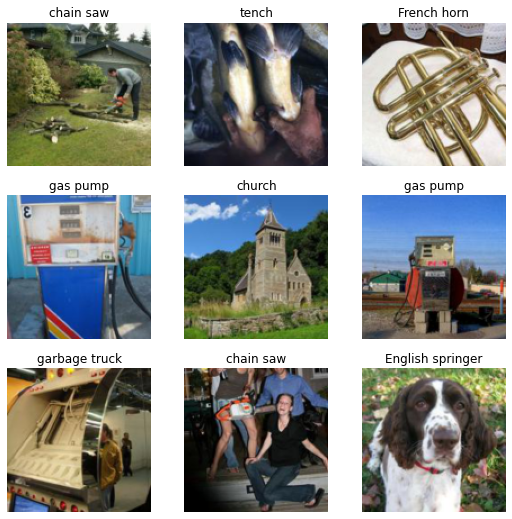

In [13]:
dls.show_batch()

In [14]:
arch = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=10)

In [15]:
arch[0]

ConvLayer(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)

In [16]:
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count=0
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children()))>0:
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)
        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new
            
    return model

In [17]:
net = convert_MP_to_blurMP(arch, nn.MaxPool2d)

In [18]:
def opt_func(ps, lr=1e-3): return Lookahead(RAdam(ps, lr=lr))

In [19]:
opt_func = opt_func

In [20]:
learn = Learner(dls, model=net, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy])

SuggestedLRs(valley=9.120108734350652e-05)

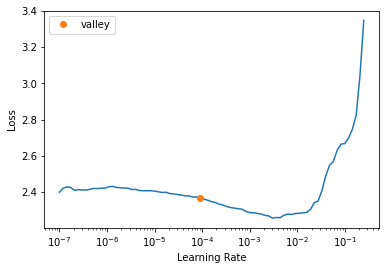

In [21]:
learn.lr_find()

In [22]:
from fastai.test_utils import synth_learner

In [23]:
synth = synth_learner()

In [24]:
synth.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,18.215076,17.301872,00:00


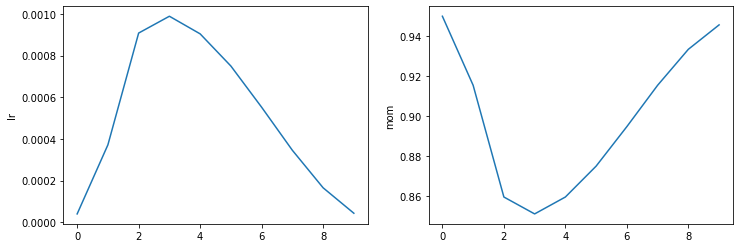

In [25]:
synth.recorder.plot_sched()

In [26]:
synth.fit_flat_cos(1, pct_start=0.72)

epoch,train_loss,valid_loss,time
0,14.919298,12.327942,00:00


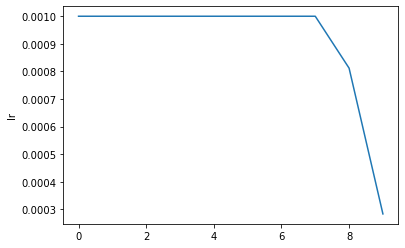

In [27]:
synth.recorder.plot_sched()

In [28]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,time
0,1.797666,2.298418,0.822420,0.478471,00:54
1,1.387756,1.307188,0.953631,0.676433,00:50
2,1.197664,1.134409,0.965860,0.756178,00:50
3,1.032258,1.013417,0.977325,0.810701,00:50
4,0.931105,0.977715,0.982166,0.823185,00:50


In [29]:
learn = Learner(dls, model=net, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy], opt_func=opt_func)

In [30]:
learn.fit_flat_cos(5, 4e-3)

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,time
0,1.048681,1.143868,0.971975,0.752357,00:50
1,1.042321,1.029428,0.976815,0.794904,00:49
2,1.002779,1.106806,0.978344,0.770191,00:49
3,0.943778,0.952219,0.981656,0.829045,00:49
4,0.814898,0.868705,0.986752,0.863694,00:49


### DataBlock Summary

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.IMAGENETTE_320)

In [3]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [4]:
item_tfms = Resize(160)
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [5]:
img_nette = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items=get_image_files,
                      splitter=RandomSplitter(),
                      get_y=Pipeline([parent_label, lbl_dict.__getitem__]),
                      item_tfms=item_tfms,
                      batch_tfms=batch_tfms
)

In [6]:
img_nette.summary(path)

Setting-up type transforms pipelines
Found 13394 items
2 datasets of sizes 10716,2678
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> dict.__getitem__ -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\light\.fastai\data\imagenette2-320\val\n03888257\n03888257_20572.JPEG
    applying PILBase.create gives
      PILImage mode=RGB size=323x320
  Pipeline: parent_label -> dict.__getitem__ -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\light\.fastai\data\imagenette2-320\val\n03888257\n03888257_20572.JPEG
    applying parent_label gives
      n03888257
    applying dict.__getitem__ gives
      parachute
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=323x320, TensorCategory(8))


Found 13394 items
2 datasets of sizes 10716,2678
Sett

In [7]:
tfms = [[PILImage.create],[parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(160)]
batch_tfms = [FlipItem(), RandomResizedCrop(160, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [9]:
items = get_image_files(path)
split_idx = GrandparentSplitter(valid_name='val')(items)
dsets = Datasets(items, tfms, splits=split_idx)
dls = dsets.dataloaders(after_item=item_tfms,after_batch=batch_tfms,bs=64, num_workers=0)

In [10]:
x = dsets.train[0]
x

(PILImage mode=RGB size=426x320, TensorCategory(0))

In [11]:
dls.train.after_item

Pipeline: Resize -- {'size': (160, 160), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [12]:
dls.train.after_batch

Pipeline: FlipItem -- {'p': 0.5} -> RandomResizedCrop -- {'size': (160, 160), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

In [13]:
for f in dls.train.after_item:
    name = f.name
    x = f(x)
    print(name, x[0])

Resize -- {'size': (160, 160), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} PILImage mode=RGB size=160x160
ToTensor TensorImage([[[104, 148, 154,  ..., 172, 177, 177],
         [111, 101, 130,  ..., 189, 195, 192],
         [ 70,  66, 123,  ..., 220, 200, 194],
         ...,
         [112, 108, 110,  ..., 152, 144, 129],
         [130, 116,  96,  ..., 118, 117, 153],
         [109, 128, 120,  ..., 168, 144, 153]],

        [[ 97, 144, 154,  ..., 175, 183, 187],
         [ 99,  96, 127,  ..., 187, 194, 195],
         [ 54,  59, 118,  ..., 212, 192, 188],
         ...,
         [138, 132, 135,  ..., 163, 156, 140],
         [157, 141, 120,  ..., 131, 130, 166],
         [137, 154, 143,  ..., 181, 157, 166]],

        [[ 97, 120,  89,  ..., 157, 166, 170],
         [ 92,  74,  72,  ..., 169, 178, 178],
         [ 38,  38,  78,  ..., 196, 176, 172],
         ...,
         [139, 131, 138,  ..., 155, 147, 132],
         [156, 139, 122,  ..., 122, 121, 157],
    

In [14]:
for f in dls.train.after_batch:
    name = f.name
    x = f(to_device(x, 'cuda'))
    print(name, x[0])

FlipItem -- {'p': 0.5} TensorImage([[[104, 148, 154,  ..., 172, 177, 177],
         [111, 101, 130,  ..., 189, 195, 192],
         [ 70,  66, 123,  ..., 220, 200, 194],
         ...,
         [112, 108, 110,  ..., 152, 144, 129],
         [130, 116,  96,  ..., 118, 117, 153],
         [109, 128, 120,  ..., 168, 144, 153]],

        [[ 97, 144, 154,  ..., 175, 183, 187],
         [ 99,  96, 127,  ..., 187, 194, 195],
         [ 54,  59, 118,  ..., 212, 192, 188],
         ...,
         [138, 132, 135,  ..., 163, 156, 140],
         [157, 141, 120,  ..., 131, 130, 166],
         [137, 154, 143,  ..., 181, 157, 166]],

        [[ 97, 120,  89,  ..., 157, 166, 170],
         [ 92,  74,  72,  ..., 169, 178, 178],
         [ 38,  38,  78,  ..., 196, 176, 172],
         ...,
         [139, 131, 138,  ..., 155, 147, 132],
         [156, 139, 122,  ..., 122, 121, 157],
         [136, 150, 144,  ..., 172, 148, 157]]], device='cuda:0',
       dtype=torch.uint8)
RandomResizedCrop -- {'size': (160,